# Pré-processamento

## Gustavo Portela Lages

### 1. Análise Textual de varredura do Corpus

#### 1.a.Corpus de documentos utilizado na pesquisa:
O Corpus escolhido foi uma coleção de 115 documentos descalssificados presentes em Economic Issues, filtrado pela coleção da National Intelligence Concil (NIC), na seção Freedom of Information Act Electronic Reading Room (FOIA) do site da Central Intelligence Agency (CIA).



# Resolução

Os modelos de *words embeddings* utilizados foram os dois algoritmos principais de treinamento para o word2vec:
1. Continuous Bag-Of-Word (CBOW); e
2. skip-gram. 

A principal diferença entre esses algoritmos é que o CBOW usa o contexto para ***prever a palavra*** e o skip-gram usa a palavra para ***prever o contexto***. 

In [1]:
import os
import pathlib
import time
import codecs
import string
import re
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import urllib
import requests
from bs4 import BeautifulSoup

import nltk
import networkx as nx
import gensim
from wordcloud import WordCloud
import textract

from IPython.core.display import Image
%matplotlib inline

In [2]:
import re
limpar = re.compile(r'\s+')
limpar1 = re.compile(r'•+')
stop_en = nltk.corpus.stopwords.words('english')
stopwords = stop_en
stopwords.extend(['-','','–', 'the', '-\n','would', '’', '”', 's', '0','1','2','3','4','5','6','7','8','9',
                  'expérttp', '://', 'www', 'nnd', 'page', 'page-', 'page-1', 'page-2', 'page-3', 'page-4', 
                  'page-5', 'page-6', 'page-7', 'page-8', 'page-9', 'page-10', '———', 'copy', '—_—7', '¥',
                  '©', 'b/d', 'rrr', 'err', 'errr', 'rr', '—™', '.','__', '--', "'", "',", '°', 'e6', "‘'",
                  ')<',"—'", ])

In [3]:
expression = ['soviets']
def limpa(text):
    list_words = text.split()
    list_words = [l.strip(string.punctuation) for l in list_words]
    list_words = [l.strip().lower() for l in list_words]
    list_words = [l.strip(string.punctuation) for l in list_words]
    list_words = [l for l in list_words if l not in stopwords]    
    input_text = ''
    for l in list_words:
        if l.lower() in expression:
            l = 'soviet'
        input_text += ' '+l        
    return str(input_text+' | ')

In [4]:
def build_neighbors(word, model, nviz=10):
    g = nx.Graph()
    g.add_node(word)
    viz1 = model.wv.most_similar(word, topn=nviz)
    g.add_weighted_edges_from([(word, v, w) for v,w in viz1 if w> 0.5] )
    for v in viz1:
        g.add_weighted_edges_from([(v[0], v2, w2) for v2,w2 in model.wv.most_similar(v[0])])
    return g

In [5]:
def print_results(model, palavra):
    print(palavra)
    for result in model.wv.most_similar(palavra):
        print(result)
    print()

## Lendo o repositório

In [6]:
onlydirs = [f for f in os.listdir('.') if os.path.isdir(os.path.join('.',f)) and not f.startswith('.')]
corpuspath = 'txt'

onlyfiles = [f for f in os.listdir(corpuspath) if os.path.isfile(os.path.join(corpuspath,f)) and not f.startswith('.')]
onlydirs.sort()

lista = []
input_text = ''
i=0
for filename in [f for f in onlyfiles if f.endswith('txt')]:
    i +=1
    print('Arquivos na pasta:', '\n')
    print(i,': ', filename)
    text = textract.process(os.path.join(corpuspath,filename)).decode('utf-8')
    list_words = text.split('.')
    list_words = [limpar.sub(' ',l) for l in list_words]
    
    for l in list_words:  
        input_text += limpa(l) 

Arquivos na pasta: 

1 :  Testimony By CIA National Intelligence Council Chairman Henry Rowen Before the Senate Committee on Ener and Natural Resources.txt
Arquivos na pasta: 

2 :  Cost of Illustrative Soviet Intercontinental Attack Force Model.txt
Arquivos na pasta: 

3 :  MILITARY BUDGETS OF SELECTED COUNTRIES.txt
Arquivos na pasta: 

4 :  Global Humanitarian Emergencies, 1993-94.txt
Arquivos na pasta: 

5 :  Prospects for West German Foreign Policy.txt
Arquivos na pasta: 

6 :  THE PROBABLE INTERRELATIONSHIPS OF THE INDEPENDENT AFRICAN STATES.txt
Arquivos na pasta: 

7 :  Sub-Saharan Africa: Implications of the AIDS Pandemic.txt
Arquivos na pasta: 

8 :  COMMUNIST AND FREE WORLD REACTIONS TO A POSSIBLE US COURSE OF ACTION.txt
Arquivos na pasta: 

9 :  Main Trends in Soviet Military Policy Soviet Economic Problems and Prospects.txt
Arquivos na pasta: 

10 :  Russia Over the Next Four Years: The Prospects for Democratization and Marketization.txt
Arquivos na pasta: 

11 :  BASIC DUTC

Arquivos na pasta: 

94 :  FOREIGN REACTIONS TO CERTAIN US COURSES OF ACTION REGARDING US FORCES IN EUROPE.txt
Arquivos na pasta: 

95 :  Communist Military Assistance Programs in Less Developed Areas.txt
Arquivos na pasta: 

96 :  The Winter of the Soviet Military: Cohesion or Collapse?.txt
Arquivos na pasta: 

97 :  Trends in Soviet General Policies.txt
Arquivos na pasta: 

98 :  IMPLICATIONS FOR THE WESTERN ALLIANCE AND US RELATIONS WITH WESTERN EUROPE.txt
Arquivos na pasta: 

99 :  PROBABLE SOVIET REACTIONS TO A US AID PROGRAM FOR ITALY.txt
Arquivos na pasta: 

100 :  GOVERNMENTAL PROGRAMS ON NATIONAL SECURITY AND INTERNATIONAL AFFAIRS FOR FY 1951.txt
Arquivos na pasta: 

101 :  THE USSR PETROLEUM INDUSTRY.txt
Arquivos na pasta: 

102 :  Peru and the US: the implications of the IPC Controversy.txt
Arquivos na pasta: 

103 :  POLITICAL AND ECONOMIC CHANGES IN WESTERN EUROPE SINCE THE LAST CONFERENCE OF FOREIGN MINISTERS.txt
Arquivos na pasta: 

104 :  THE EFFECTS OF CERTAIN VOSSIBLE

## Criando uma lista de sentenças

In [7]:
# Lista de sentenças
sentences_strings_ted = []
for line in input_text.split('|'):
    sentences_strings_ted.extend([line])
    
# tokenização
sentences_ted = []
for sent_str in sentences_strings_ted:
    tokens = sent_str.lower().split()
    sentences_ted.append(tokens)

In [8]:
from gensim.models import Word2Vec
#CBOW
model_0 = Word2Vec(sentences=sentences_ted, size=100, window=5, min_count=40, workers=4, sg=0)

#Skip-gram
model_1 = Word2Vec(sentences=sentences_ted, size=100, window=5, min_count=40, workers=4, sg=1)

## imprimindo: CBOW 

In [9]:
print_results(model_0,'ussr')

ussr
('satellites', 0.9318273067474365)
('tries', 0.8987505435943604)
('coun', 0.8919318914413452)
('example', 0.8686939477920532)
('ern', 0.866705060005188)
('loss', 0.8646659851074219)
('im', 0.8622024059295654)
('credits', 0.8580442667007446)
('austria', 0.8530396223068237)
('area', 0.852082371711731)



In [25]:
print_results(model_1,'ussr')

ussr
('alone', 0.6414995193481445)
('zones', 0.629094660282135)
('possibly', 0.6121903657913208)
('gives', 0.6093751192092896)
('considered', 0.6066901087760925)
('firm', 0.6064708232879639)
('whole', 0.6060540676116943)
('orbit', 0.6059299111366272)
('relative', 0.6012628674507141)
('constitute', 0.5999215841293335)



## imprimindo: skip-gram 

In [21]:
model_1.wv.most_similar('ussr')

[('alone', 0.6414995193481445),
 ('zones', 0.629094660282135),
 ('possibly', 0.6121903657913208),
 ('gives', 0.6093751192092896),
 ('considered', 0.6066901087760925),
 ('firm', 0.6064708232879639),
 ('whole', 0.6060540676116943),
 ('orbit', 0.6059299111366272),
 ('relative', 0.6012628674507141),
 ('constitute', 0.5999215841293335)]

# Redes de palavras para o termo "*urss*" (CBOW)

/home/gu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


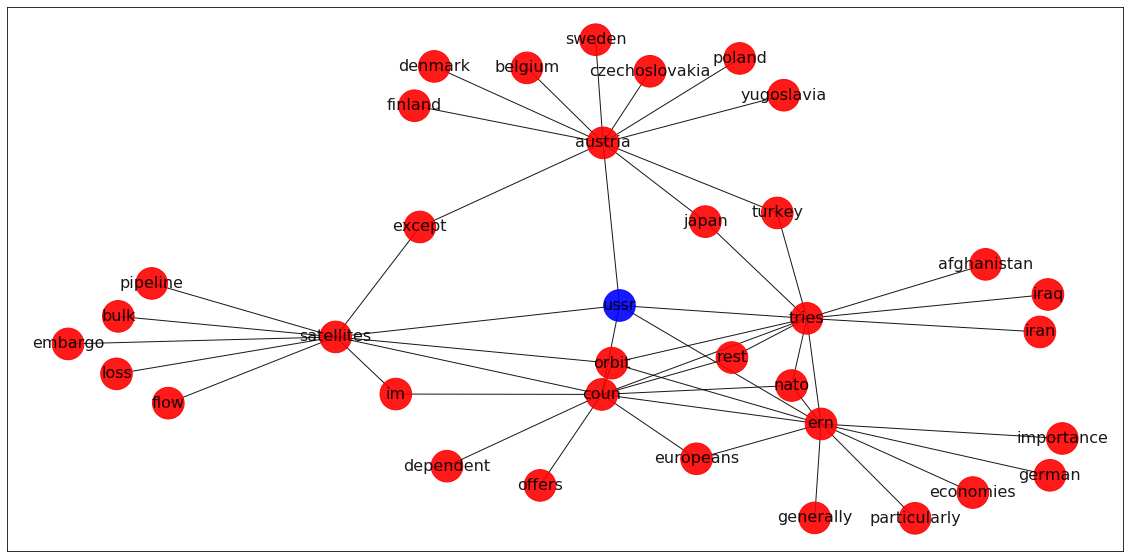

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
word = 'ussr'

g = build_neighbors(word, model_0,5);
cols = ['r']*len(g.nodes()); 
cols[0]='blue'
pos = nx.spring_layout(g, iterations=300)
nx.draw_networkx(g, pos=pos, node_color=cols, node_size=1000, alpha=0.9, font_size= 16)

# Redes de palavras para o termo "*urss*"  (skip-gram)

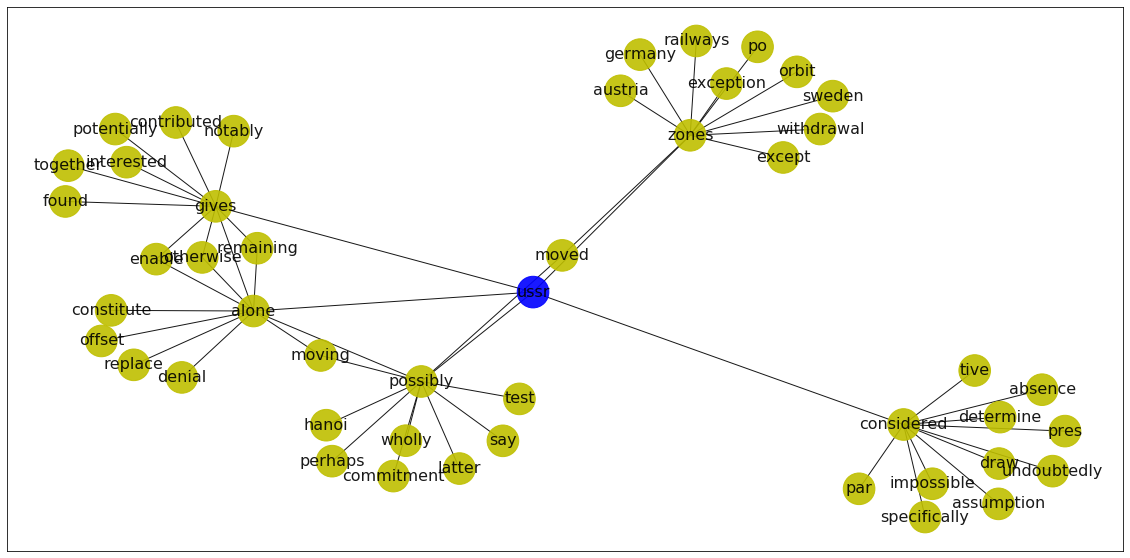

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
word = 'ussr'

g = build_neighbors(word, model_1,5);
cols = ['y']*len(g.nodes()); 
cols[0]='blue'
pos = nx.spring_layout(g, iterations=300)
nx.draw_networkx(g, pos=pos, node_color=cols, node_size=1000, alpha=0.9, font_size= 16)

In [26]:
print_results(model_0,'soviet')

soviet
('strategic', 0.681423008441925)
('potential', 0.667866587638855)
('primarily', 0.6550830602645874)
('reduce', 0.6486876010894775)
('capabilities', 0.6448086500167847)
('viet', 0.6415095329284668)
('military', 0.6403529644012451)
('strength', 0.6327085494995117)
('maintain', 0.6220411658287048)
('expansion', 0.6204479336738586)



In [27]:
print_results(model_1,'soviet')

soviet
('viet', 0.6943706274032593)
('ussr’s', 0.6749670505523682)
("moscow's", 0.5667557716369629)
('bloc’s', 0.5646693706512451)
('expanding', 0.5635499954223633)
('significant', 0.554236114025116)
('modest', 0.5528678894042969)
('related', 0.5494974255561829)
('pres', 0.5475271940231323)
('continuing', 0.5470587611198425)



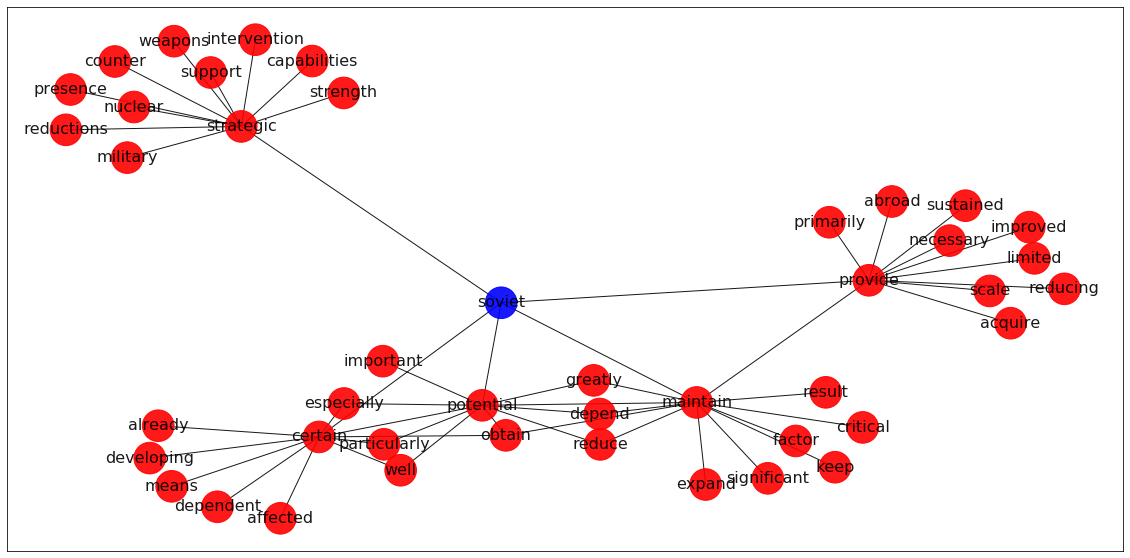

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
word = 'soviet'

g = build_neighbors(word, model_0,5);
cols = ['r']*len(g.nodes()); 
cols[0]='blue'
pos = nx.spring_layout(g, iterations=300)
nx.draw_networkx(g, pos=pos, node_color=cols, node_size=1000, alpha=0.9, font_size= 16)

/home/gu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


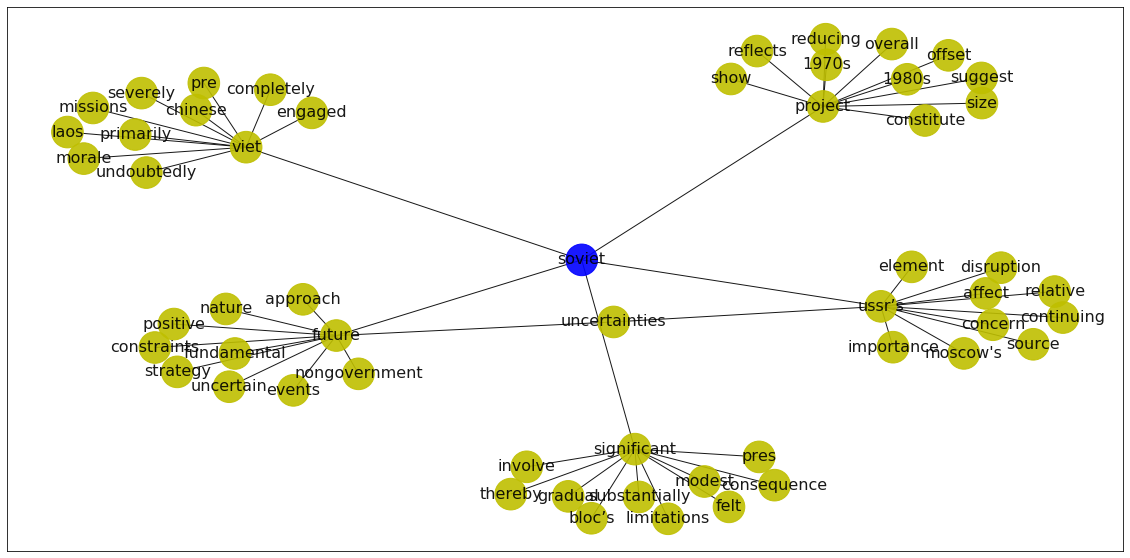

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
word = 'soviet'

g = build_neighbors(word, model_1,5);
cols = ['y']*len(g.nodes()); 
cols[0]='blue'
pos = nx.spring_layout(g, iterations=300)
nx.draw_networkx(g, pos=pos, node_color=cols, node_size=1000, alpha=0.9, font_size= 16)

In [30]:
print_results(model_0,'brazil')

brazil
('uar', 0.8822234869003296)
('banks', 0.8810585737228394)
('refugees', 0.8803904056549072)
('occurred', 0.8796871304512024)
('came', 0.8749505281448364)
('followed', 0.8616948127746582)
('tween', 0.8554093837738037)
('existence', 0.8553272485733032)
('others', 0.8542169332504272)
('record', 0.8537944555282593)



In [34]:
print_results(model_1,'brazil')

brazil
('banks', 0.8311260938644409)
('peru', 0.8140648603439331)
('debt', 0.7888144254684448)
('creditors', 0.7762261629104614)
('imf', 0.7624154090881348)
('brazilian', 0.7611452341079712)
('guatemala', 0.7392417192459106)
('payments', 0.7365383505821228)
('bilateral', 0.7011013031005859)
('argentina', 0.6869387626647949)



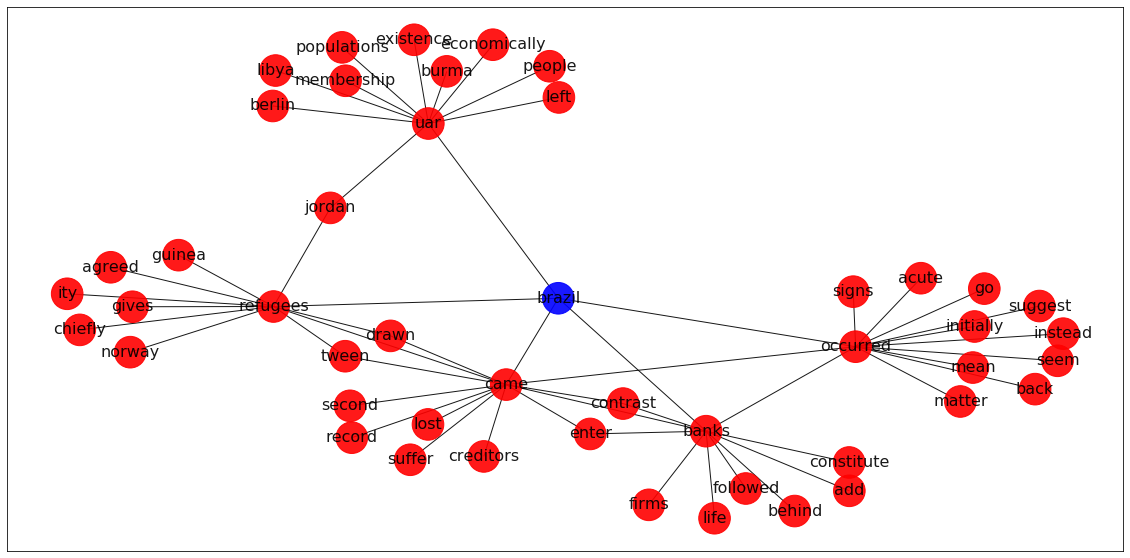

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
word = 'brazil'

g = build_neighbors(word, model_0,5);
cols = ['r']*len(g.nodes()); 
cols[0]='blue'
pos = nx.spring_layout(g, iterations=300)
nx.draw_networkx(g, pos=pos, node_color=cols, node_size=1000, alpha=0.9, font_size= 16)

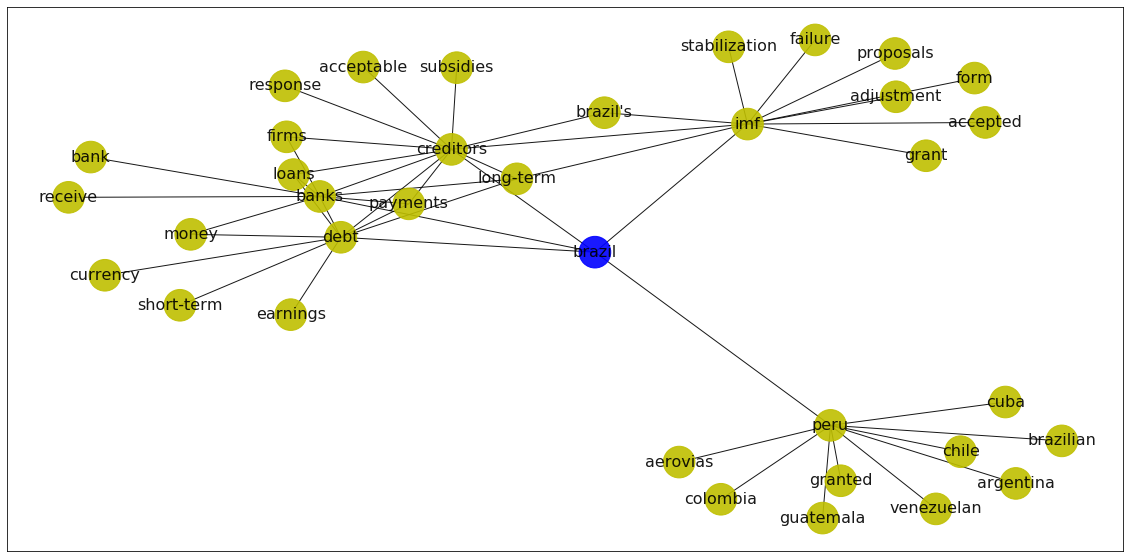

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
word = 'brazil'

g = build_neighbors(word, model_1,5);
cols = ['y']*len(g.nodes()); 
cols[0]='blue'
pos = nx.spring_layout(g, iterations=300)
nx.draw_networkx(g, pos=pos, node_color=cols, node_size=1000, alpha=0.9, font_size= 16)

In [14]:
print(sentences_ted[:200])

[['im', 'wo'], ['stengi”horom', 'ay', '2s', 'testimony', 'cia', 'national', 'intelligence', 'council', 'chairman', 'henry', 'rowen'], ['senate', 'committee', 'ener', 'natural', 'resources', 'february', '18', '1983', 'mr'], ['chairman', 'distinguished', 'members', 'committee'], ['welcome', 'opportunity', 'present', 'central', 'intelligence', "agency's", 'views', 'world', 'energy', 'situation', 'implications'], ['u', 'aa', 'analysis', 'present', 'oil', 'market', 'situation', 'outlook', 'similar', 'testimony', 'presented', 'department', 'energy'], ['believe', 'general', 'cut', 'nominal', 'oil', 'prices', 'highly', 'likely', 'coming', 'weeks'], ['persistent', 'softness', 'world', 'oil', 'market', 'growing', 'financial', 'difficulties', 'several', 'oil', 'producers', 'contributing', 'possibility'], ['market', 'weakness', 'due', 'number', 'factors', 'economic', 'growth', 'continues'], ['weak', 'recovery', 'expected', 'latter', 'half', 'year'], ['unseasonably', 'warm', 'weather', 'northern', 

In [15]:
print(input_text[400:800])

rgy |  believe general cut nominal oil prices highly likely coming weeks |  persistent softness world oil market growing financial difficulties several oil producers contributing possibility |  market weakness due number factors economic growth continues |  weak recovery expected latter half year |  unseasonably warm weather northern hemisphere held oil energy use sharply normal winter levels |  c


In [16]:
print('Nº de termos: '+str(len(model_0.wv.vocab))+'\n')
for word in model_0.wv.vocab:
    print(word)

Nº de termos: 2251

im
cia
national
intelligence
council
chairman
committee
natural
resources
february
18
members
opportunity
present
central
views
world
energy
situation
implications
u
analysis
oil
market
outlook
similar
department
believe
general
cut
prices
highly
likely
coming
growing
financial
difficulties
several
producers
possibility
weakness
due
number
factors
economic
growth
continues
weak
recovery
expected
latter
half
year
weather
northern
held
use
sharply
normal
winter
levels
consumption
lower
remain
surplus
company
needs
pressure
reduce
purchases
future
conservation
away
continue
rates
slower
past
three
years
de
secret
effect
crude
production
31
million
17
january
may
one
free
declined
45
1980
44
per
african
light
level
29
official
next
critical
period
demand
remains
price
decline
thousand
day
reduction
sales
since
beginning
mexico
facing
prospect
either
increase
reducing
output
oo
uk
exports
compared
saudi
arabia
averaged
prospects
far
individual
reluctant
drop
attempt
avoi

salvador
guatemala
nicaragua
pacific
panama
peru
korea
kind
every
rail
coastal
shortage
numerous
old
trained
1,000
1989
quality
extensive
center
parties
rolling
standard
assist
religious
equipped
cities
maintained
modern
vehicle
et
1965
participated
preparation
nsa
bureau
investigation
contents
conclusions
election
considerations
relations
nuclear
longer
principal
adopt
strength
position
whatever
emphasis
developments
practical
lines
paras
retain
berlin
ties
certainly
initiative
expand
moves
question
steps
marked
independence
opportunities
fundamental
find
forced
events
seek
exploit
popular
movement
tend
favorable
integration
adverse
germans
goals
objectives
powers
defensive
postwar
conventional
desire
exercise
positions
aware
indeed
nationalist
sense
associated
1964
seven
never
establish
form
trade
hopes
evident
likelihood
wish
goal
concluded
initiatives
necessity
accept
status
interested
man
firm
radical
involvement
cooperative
domestic
social
society
1963
democratic
party
substantia

In [35]:
print('Nº de termos: '+str(len(model_1.wv.vocab))+'\n')
for word in model_1.wv.vocab:
    print(word)

Nº de termos: 2251

im
cia
national
intelligence
council
chairman
committee
natural
resources
february
18
members
opportunity
present
central
views
world
energy
situation
implications
u
analysis
oil
market
outlook
similar
department
believe
general
cut
prices
highly
likely
coming
growing
financial
difficulties
several
producers
possibility
weakness
due
number
factors
economic
growth
continues
weak
recovery
expected
latter
half
year
weather
northern
held
use
sharply
normal
winter
levels
consumption
lower
remain
surplus
company
needs
pressure
reduce
purchases
future
conservation
away
continue
rates
slower
past
three
years
de
secret
effect
crude
production
31
million
17
january
may
one
free
declined
45
1980
44
per
african
light
level
29
official
next
critical
period
demand
remains
price
decline
thousand
day
reduction
sales
since
beginning
mexico
facing
prospect
either
increase
reducing
output
oo
uk
exports
compared
saudi
arabia
averaged
prospects
far
individual
reluctant
drop
attempt
avoi

black
republics
open
regions
keep
suffer
inadequate
rely
requires
china
continuing
controlled
ern
home
improved
vietnam
try
adequate
latin
cuba
calls
stimulate
burma
costa
rica
salvador
guatemala
nicaragua
pacific
panama
peru
korea
kind
every
rail
coastal
shortage
numerous
old
trained
1,000
1989
quality
extensive
center
parties
rolling
standard
assist
religious
equipped
cities
maintained
modern
vehicle
et
1965
participated
preparation
nsa
bureau
investigation
contents
conclusions
election
considerations
relations
nuclear
longer
principal
adopt
strength
position
whatever
emphasis
developments
practical
lines
paras
retain
berlin
ties
certainly
initiative
expand
moves
question
steps
marked
independence
opportunities
fundamental
find
forced
events
seek
exploit
popular
movement
tend
favorable
integration
adverse
germans
goals
objectives
powers
defensive
postwar
conventional
desire
exercise
positions
aware
indeed
nationalist
sense
associated
1964
seven
never
establish
form
trade
hopes
eviden